# **Finding Waldo** 
### PYTORCH EDITION FASTER RCNN

![Gift](https://freight.cargo.site/w/600/i/0bec2199b74fc15b8b4278ffeb46dfbc7e49b6ec94bb7dea05ace57e77bf5c10/5A_WALLY_gif_Pulando_v1.gif)

### Required Libraries



In [1]:
# # Desinstalar numpy incompatible
# %pip uninstall -y numpy

# # Instalar numpy compatible y otras dependencias
# %pip install numpy==1.23.5 torch==2.0.0 torchvision==0.15.1 tensorflow-gpu==2.10.0 \
# matplotlib==3.6.0 pandas==1.3.3 opencv-python==4.6.0.66 scipy==1.5.4 seaborn==0.11.2 \
# typing-extensions==4.0.1 pillow==9.2.0 gitpython==3.1.30 tqdm==4.64.1 setuptools==65.5.0 \
# pyyaml==6.0 psutil==5.9.0 thop==0.1.1.post2209072238

# %pip install testresources

# %pip install pickleshare

In [2]:
%cd /mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection

# Importar librerías básicas
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from torchvision import transforms as T
import matplotlib.pyplot as plt
import yaml
import sys
import glob
import shutil
import random
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageEnhance
from collections import OrderedDict
from torch.optim import AdamW

/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection


# Función para visualizar las imagenes

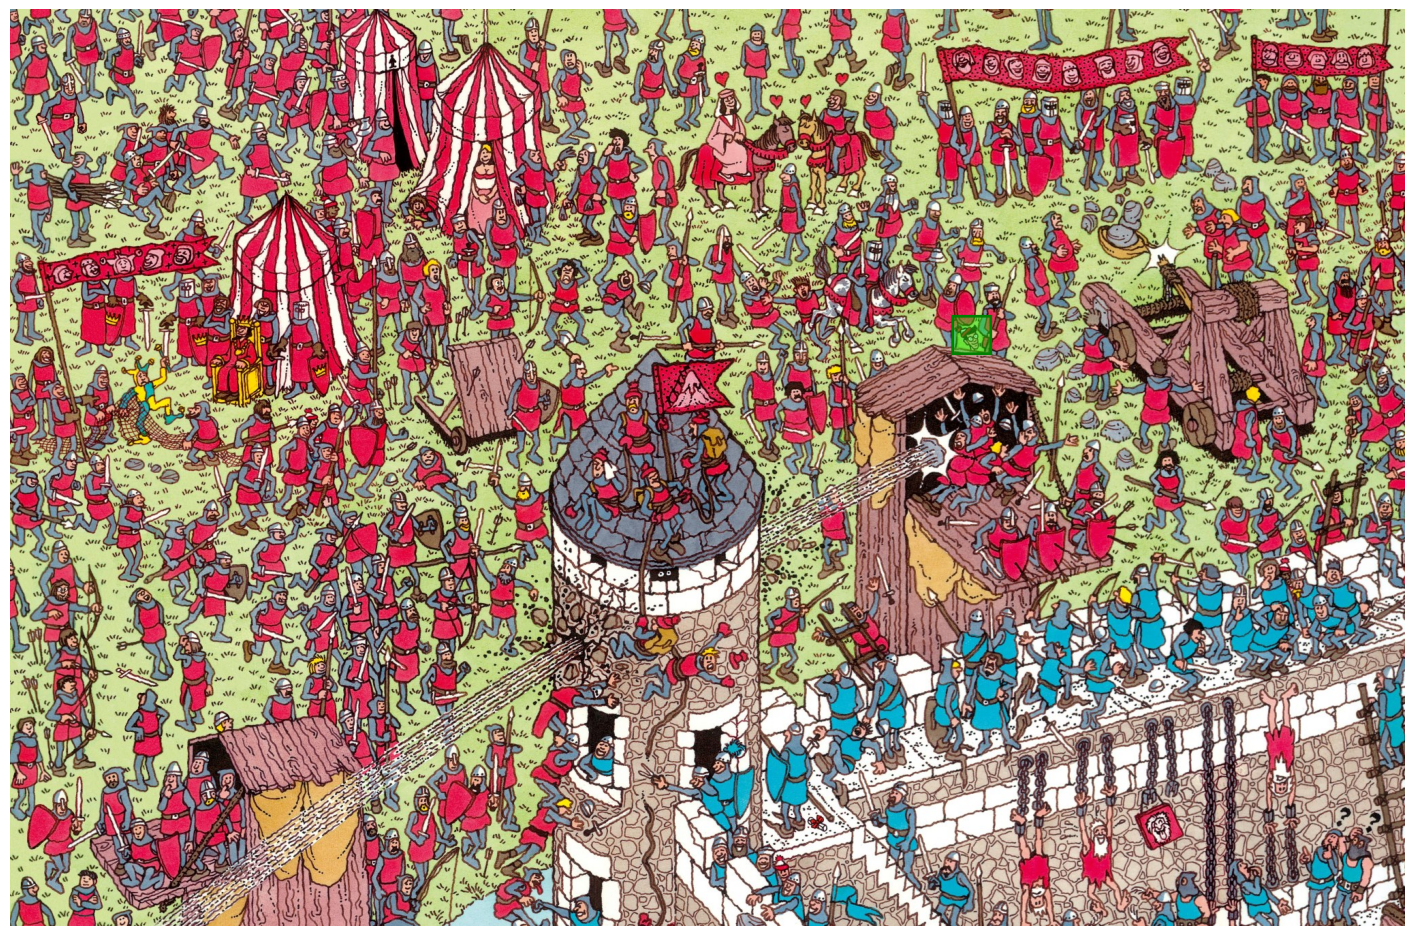

In [3]:
def show_image_with_bounding_box(xml_path, image_path):
    # Cargar la imagen
    image = Image.open(image_path).convert("RGB")
    
    # Intentar leer el contenido del archivo XML
    try:
        with open(xml_path, 'r') as file:
            content = file.read().strip()  # Eliminar espacios en blanco y saltos de línea
            
        # Verificar si el archivo contiene "-1", lo que indica que no hay detecciones
        if content == "-1":
            print(f"El archivo de etiquetas {xml_path} indica que no hay detecciones. Mostrando la imagen sin bounding boxes.")
            plt.figure(figsize=(18, 18))
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            return  # Salir de la función si el XML indica que no hay detecciones

        # Parsear el contenido XML
        root = ET.fromstring(content)
        
        # Crear una capa para las bounding boxes
        overlay = Image.new("RGBA", image.size, (255, 255, 255, 0))
        
        # Obtener y dibujar las coordenadas de cada bounding box en el overlay
        for obj in root.findall('object'):
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            
            draw = ImageDraw.Draw(overlay)
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="green", width=4, fill=(0, 255, 0, 100))

        # Superponer el overlay con las bounding boxes sobre la imagen original
        combined = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    except ET.ParseError:
        # En caso de error de parseo, mostrar solo la imagen sin bounding boxes
        print(f"Error al analizar {xml_path}. Mostrando la imagen sin bounding boxes.")
        combined = image

    # Mostrar la imagen resultante
    plt.figure(figsize=(18, 18))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()


# Ejemplo de uso:
# show_image_with_bounding_box("/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/annotations/3.xml", "/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/images/3.jpg")

show_image_with_bounding_box("/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/annotations_train/3.xml", "/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/images/train/3.jpg")


# Estructura de carpetas

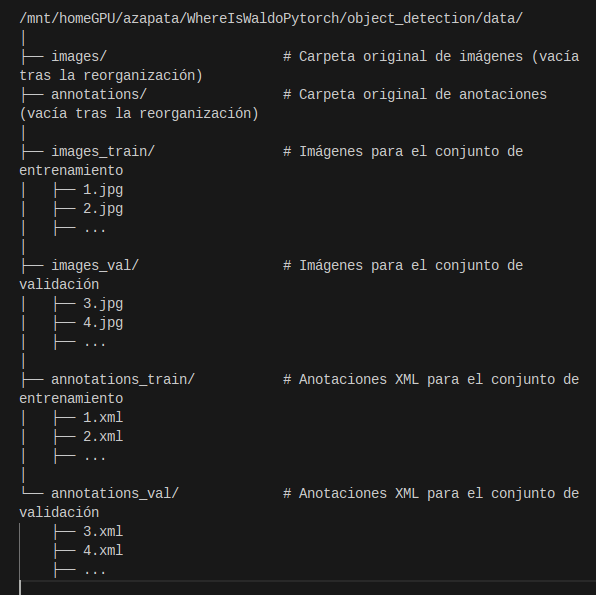

### Comprobamos que se ejecute en modo GPU

In [4]:
# Verificar si hay GPU disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"El entrenamiento se está ejecutando en: {device}")

El entrenamiento se está ejecutando en: cuda


# **Fine Tunning FasterRCNN**

# **Descargamos el modelo de la documentación oficial**

[ENLACE A LA DOCUMENTACIÓN](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Cargar el modelo Faster R-CNN con pesos preentrenados
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights)

## Configuramos el número de clases

In [6]:
# Ajustar el número de clases (1 para fondo + 1 para la clase Waldo)
num_classes = 2  # Fondo + 1 clase

# Obtener el número de características de entrada de la capa final del clasificador
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Reemplazar la capa de predicción final para el número correcto de clases
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Verificamos que se entrene en GPU

In [7]:
# Verificar si hay GPU disponible y enviar el modelo al dispositivo
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print("Modelo configurado correctamente con el número de clases:", num_classes)

/home/azapata/.conda/envs/ENWALPYTORCHFasterRCNN/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Modelo configurado correctamente con el número de clases: 2


# **Creamos la clase CustomDataset para Faster R-CNN**

In [8]:
from torchvision.transforms import functional as F

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        """
        Inicializa el dataset personalizado.

        Args:
            images_dir (str): Ruta al directorio que contiene las imágenes.
            annotations_dir (str): Ruta al directorio que contiene las anotaciones XML.
            transforms (callable, optional): Transformaciones a aplicar a las imágenes.
        """
        # Guardamos las rutas de los directorios de imágenes y anotaciones
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        
        # Listamos y ordenamos los archivos en el directorio de imágenes y anotaciones
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.annotation_files = sorted([f for f in os.listdir(annotations_dir) if f.endswith('.xml')])
    
    def __len__(self):
        """
        Este método define cuántos elementos tiene el dataset, 
        necesario para que PyTorch sepa cuántas iteraciones hacer sobre el dataset

        """
        return len(self.image_files)
    
    def __getitem__(self, idx):
        """
        Este es el método principal que se encarga de cargar cada imagen y sus anotaciones correspondientes.
        """
         # Cargar la imagen
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")
        
        # Cargar y procesar la anotación
        annotation_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        boxes, labels = self.parse_xml(annotation_path)
        
        # Convertir las cajas y etiquetas a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Crear el diccionario `target` requerido por Faster R-CNN
        target = {"boxes": boxes, "labels": labels}
        
        # Aplicar transformaciones si están definidas
        img = F.to_tensor(img)  # Convertir la imagen a tensor
        if self.transforms:
            img = self.transforms(img)
        
        return img, target
    
    def parse_xml(self, annotation_path):
        """
        Este método procesa el archivo XML para extraer las cajas delimitadoras 
        y las etiquetas de cada objeto en la imagen.
        """
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.findall("object"):
            # Asignar directamente el valor `1` a la etiqueta "Waldo"
            labels.append(1)  # Todos los objetos son "Waldo", con etiqueta `1`
            
            # Extraer coordenadas de la caja delimitadora
            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
        
        return boxes, labels

# Configuramos los dataloaders

In [9]:
from torch.utils.data import DataLoader

# Definir la función collate_fn para manejar lotes con diferentes números de objetos
def collate_fn(batch):
    return tuple(zip(*batch))

# Directorios
TRAIN_DIR_IMAGES = '/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/images/train'
TRAIN_DIR_LABELS = '/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/annotations_train'
VALID_DIR_IMAGES = '/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/images/val'
VALID_DIR_LABELS = '/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/annotations_val'

# Crear los datasets de entrenamiento y validación
train_dataset = CustomDataset(images_dir=TRAIN_DIR_IMAGES, annotations_dir=TRAIN_DIR_LABELS)
val_dataset = CustomDataset(images_dir=VALID_DIR_IMAGES, annotations_dir=VALID_DIR_LABELS)


# Crear DataLoader para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# Entrenamiento del modelo

In [10]:
# # Configurar el optimizador
# import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Bucle de entrenamiento
# num_epochs = 1  # Empieza con una época para probar

# for epoch in range(num_epochs):
#     model.train()  # Poner el modelo en modo de entrenamiento
#     train_loss = 0

#     for images, targets in train_loader:
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         # Adelante y retropropagación
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         train_loss += losses.item()
        
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
    
#     avg_train_loss = train_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")


In [11]:
# model.train()  # Temporalmente en modo de entrenamiento
# val_loss = 0
# with torch.no_grad():
#     for images, targets in val_loader:
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         # Calcular la pérdida
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         val_loss += losses.item()

#     avg_val_loss = val_loss / len(val_loader)
#     print(f"Validation Loss: {avg_val_loss:.4f}")

# model.eval()  # Volver al modo de evaluación después de la validación


# Vemos que todo funciona, vamos a mejorar el entrenamiento

In [12]:
# import torch.optim as optim

# # Parámetros configurables
# learning_rate = 0.001  # Ajusta esta tasa de aprendizaje según tus necesidades
# optimizer_type = 'AdamW'  # Cambia a 'SGD' si quieres probar con SGD

# # Configurar el optimizador
# if optimizer_type == 'AdamW':
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# elif optimizer_type == 'SGD':
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# else:
#     raise ValueError("Tipo de optimizador no soportado. Usa 'AdamW' o 'SGD'")


In [13]:
# import matplotlib.pyplot as plt

# # Bucle de entrenamiento con Early Stopping
# num_epochs = 10  # Ajusta el número de épocas según tus necesidades
# patience = 3  # Número de épocas sin mejora antes de detener el entrenamiento
# best_val_loss = float('inf')
# epochs_no_improve = 0
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()  # Poner el modelo en modo de entrenamiento
#     train_loss = 0

#     for images, targets in train_loader:
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         # Adelante y retropropagación
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         train_loss += losses.item()
        
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

#     # Validación
#     model.eval()  # Poner el modelo en modo de evaluación
#     val_loss = 0
#     with torch.no_grad():
#         for images, targets in val_loader:
#             images = [image.to(device) for image in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             # Calcular la pérdida en modo de evaluación
#             model.train()  # Cambiar temporalmente a modo de entrenamiento
#             loss_dict = model(images, targets)
#             model.eval()  # Volver a modo de evaluación
#             losses = sum(loss for loss in loss_dict.values())
#             val_loss += losses.item()

#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
#     print(f"Validation Loss: {avg_val_loss:.4f}")

#     # Early Stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print(f"Early stopping triggered after {epoch+1} epochs")
#             break

# # Graficar las pérdidas
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Validation Loss')
# plt.legend()
# plt.show()


In [14]:
# import os
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

# num_epochs = 30

# # Configurar el optimizador y el scheduler
# optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.0001)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce lr cada 5 épocas

# # Configurar TensorBoard
# writer = SummaryWriter()

# # Early stopping
# patience = 10
# epochs_no_improve = 0
# train_losses = []
# val_losses = []

# # Cargar best_val_loss si existe
# best_val_loss_file = "best_val_loss.txt"
# if os.path.exists(best_val_loss_file):
#     with open(best_val_loss_file, "r") as f:
#         best_val_loss = float(f.read().strip())
#     print(f"Loaded best_val_loss: {best_val_loss}")
# else:
#     best_val_loss = float('inf')

# # Bucle de entrenamiento
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
    
#     for images, targets in train_loader:
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         # Adelante y retropropagación
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         train_loss += losses.item()
        
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
#     writer.add_scalar("Loss/train", avg_train_loss, epoch)

#     # Validación
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for images, targets in val_loader:
#             images = [image.to(device) for image in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             # Calcular la pérdida de validación temporalmente en modo de entrenamiento
#             model.train()
#             loss_dict = model(images, targets)
#             model.eval()
#             losses = sum(loss for loss in loss_dict.values())
#             val_loss += losses.item()

#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
#     writer.add_scalar("Loss/val", avg_val_loss, epoch)
#     print(f"Validation Loss: {avg_val_loss:.4f}")

#     # Early Stopping y guardar el mejor modelo
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         epochs_no_improve = 0
        
#         # Guardar el mejor modelo
#         torch.save(model.state_dict(), "best_model.pth")
#         print("Nuevo mejor modelo guardado con Validation Loss:", avg_val_loss)
        
#         # Guardar best_val_loss en archivo de texto
#         with open(best_val_loss_file, "w") as f:
#             f.write(str(best_val_loss))
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print("Early stopping triggered")
#             break
    
#     # Step del scheduler
#     scheduler.step()

# writer.close()

# # Graficar las pérdidas
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Validation Loss')
# plt.legend()
# plt.show()


In [15]:
model.load_state_dict(torch.load('/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/best_model.pth'))

# Cambiar el modelo a modo de evaluación
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

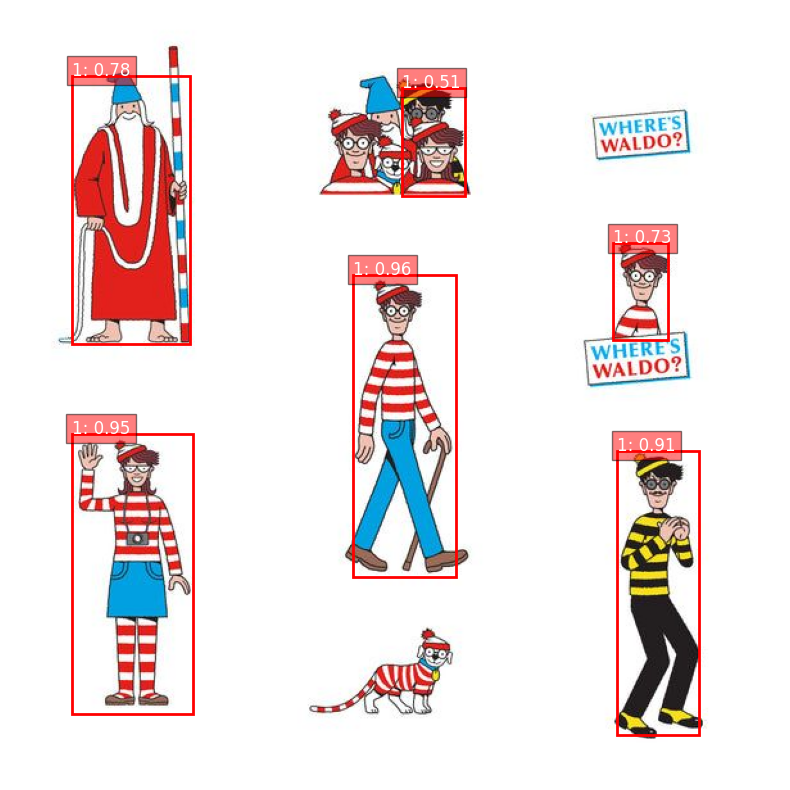

In [16]:
from PIL import Image
import torchvision.transforms as T

# Función para preprocesar la imagen
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Cargar y convertir a RGB
    transform = T.ToTensor()  # Convertir a tensor
    image = transform(image).unsqueeze(0)  # Añadir dimensión de lote
    return image.to(device)

# Cargar y preprocesar la imagen
image_path = "/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/test/images/1.jpg"  
# image_path = "/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/images/train/4.jpg"  
image = preprocess_image(image_path)

# Realizar inferencia
with torch.no_grad():
    outputs = model(image)


# Definir un umbral de confianza para filtrar las detecciones
confidence_threshold = 0.5

# Extraer las predicciones
boxes = outputs[0]['boxes'].cpu().numpy()
labels = outputs[0]['labels'].cpu().numpy()
scores = outputs[0]['scores'].cpu().numpy()

# Filtrar por confianza
filtered_boxes = boxes[scores >= confidence_threshold]
filtered_labels = labels[scores >= confidence_threshold]
filtered_scores = scores[scores >= confidence_threshold]


import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convertir la imagen a formato numpy para visualización
image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Configurar la visualización
plt.figure(figsize=(10, 10))
plt.imshow(image_np)

# Añadir las cajas delimitadoras
ax = plt.gca()
for i, box in enumerate(filtered_boxes):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    label = f"{filtered_labels[i]}: {filtered_scores[i]:.2f}"
    plt.text(xmin, ymin, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()


In [22]:
import os
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as T

# Configuración
confidence_threshold = 0.5
test_images_path = "/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/test/images"
test_labels_path = "/mnt/homeGPU/azapata/WhereIsWaldoPytorchFasterRCNN/object_detection/data/test/labels"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Función para preprocesar la imagen
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Función para leer el archivo XML y obtener las etiquetas reales
def parse_xml(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall("object"):
        labels.append(1)  # 1 representa la clase "Waldo"
    return labels

# Listas para almacenar las etiquetas verdaderas y las predicciones
all_true_labels = []
all_pred_labels = []

# Iterar sobre todas las imágenes en el conjunto de prueba
for image_name in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_name)
    annotation_path = os.path.join(test_labels_path, image_name.replace('.jpg', '.xml'))
    
    # Verificar que exista el archivo de etiquetas correspondiente
    if not os.path.isfile(annotation_path):
        print(f"Etiqueta no encontrada para {image_name}")
        continue

    # Preprocesar la imagen
    image = preprocess_image(image_path)

    # Realizar inferencia
    with torch.no_grad():
        outputs = model(image)

    # Extraer las predicciones del modelo
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].cpu().numpy()

    # Filtrar predicciones según el umbral de confianza
    filtered_pred_labels = pred_labels[pred_scores >= confidence_threshold]

    # Leer etiquetas reales desde el archivo XML
    true_labels = parse_xml(annotation_path)

    # Ajustar las listas de predicciones y etiquetas reales
    if len(filtered_pred_labels) > len(true_labels):
        # Exceso de predicciones: agregamos 0s para las etiquetas reales faltantes
        all_true_labels.extend(true_labels + [0] * (len(filtered_pred_labels) - len(true_labels)))
        all_pred_labels.extend(filtered_pred_labels.tolist())
    elif len(filtered_pred_labels) < len(true_labels):
        # Falta de predicciones: agregamos 0s para las predicciones faltantes
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(filtered_pred_labels.tolist() + [0] * (len(true_labels) - len(filtered_pred_labels)))
    else:
        # Si coinciden, simplemente agregamos las etiquetas y predicciones
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(filtered_pred_labels.tolist())

# Calcular métricas de precisión, recall y F1 Score para el conjunto de prueba
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_pred_labels, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.5238
Recall: 0.7857
F1 Score: 0.6286
